# Wasserstein GAN

Wassertein GAN (WGAN) is a variant of the traditional GAN system, but attempt to solve some of the common problems that GANs face such as mode-collapse, training instability, and difficulty to balance the generator and discriminator. Lets quickly remind ourselves of the original GAN Formulation:

## GAN Loss Function
$$Loss = \min_G \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))$$

Our goal is to simulteously train a discriminator that maximizes this loss, which in effect maximizes the log-probability and makes a confident discriminator, and also minimize this loss by training a generator that can confidently fool the discriminator. Typically this loss function is jusy Binary Cross Entropy. 

The problem is, we are using the discriminator to update our generator. If our discriminator becomes really good, and with near 100% probability able to detect if an image is real or fake, then $(1-D(G(z)))$ will be close to 0, and the gradients flowing to our generator will then also be close to 0. 

### Earth Movers Distance

WGAN makes a change to use the Earth Movers distance as the loss rather than Binary Cross Entropy which provides more prominent gradients. The Earth Movers Distance is a measure of dissimilarity between two frequency densities. This metric comes from an area of study known as Optimal Transport. Optimal transport is the study of how we can move one distribution of mass to another while minmizing cost. When we apply the Earth Movers Distance to probability distributions, it is known as the Wasserstein distance.

Imagine you run a shipping company and need to figure out the logistics of how you can deliver packages from your warehouse to parts of the city. Lets say today you have 20 packages to deliver. You could randomly select houses to drive to, but you may end up driving back and forth around the city a lot. Instead you want to find the most optimal path to all the houses that minimize the total travel distance, time and gas used. 

Another cool application of Earth Movers Distance is for image retrieval. You can produce a feature vector for images that contain information like color, texture or basic structural features which acts as the distribution representing that image. We can then calculate the Earth Movers Distance between the vector of the image we want and all other images to see how much "effort" it would take to match the featue distributions, and the one with the lowest will be the most similar image to retrieve. 

### Example of The Earth Movers Distance

You can see a more clear example at this incredible [blog post](https://lilianweng.github.io/posts/2017-08-20-gan/) and ill be doing a similar example here:

Lets say we have the following discrete distributions:

$$P_1 = 1, P_2 = 2, P_3, = 5, P_4 = 3$$
$$Q_1 = 3, Q_2 = 1, Q_3, = 2, Q_4 = 5$$

To compute the cost, it is the amount moved multipled by the distance moved. The amount is the number (i.e. we want to move 1 from $P_2$ to $P_3$) and the distance moved is how many steps we moved it over (i.e $P_1$ to $P_2$ is a distance of 1 and $P_1$ to $P_3$ is a distance of 2)

Our goal is to move $P$ around to match $Q$, but you can imagine there are a bunch of ways to do this. For example:

#### Option 1:

- Move 2 from $P_2$ to $P_1$. $Q_1$ and $P_1$ now match up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 0, P_3, = 5, P_4 = 3$$

- Move 1 from $P_3$ to $P_2$. $Q_2$ and $P_2$ now match up, and we incur a cost of 1 (amount moved) * 1 (distance moved) = 1

$$P_1 = 3, P_2 = 1, P_3, = 4, P_4 = 3$$

- Move 2 from $P_3$ to $P_4$. Everything now matches up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 1, P_3, = 2, P_4 = 5$$

**TOTAL COST:** 5

#### Option 2:

- Move 2 from $P_2$ to $P_4$. $Q_4$ and $P_4$ now match up, and we incur a cost of 2 (amount moved) * 2 (distance moved) = 4

$$P_1 = 1, P_2 = 0, P_3, = 5, P_4 = 5$$

- Move 3 from $P_3$ to $P_2$. $Q_3$ and $P_3$ now match up, we incur a cost of 3 (amount moved) * 1 (distance moved) = 3

$$P_1 = 1, P_2 = 3, P_3, = 2, P_4 = 5$$

- Move 2 from $P_2$ to $P_1$. Everything now matches up, and we incur a cost of 2 (amount moved) * 1 (distance moved) = 2

$$P_1 = 3, P_2 = 1, P_3, = 2, P_4 = 5$$

**TOTAL COST:** 9

Both of these options are totally valid and will get us to our target distribution $Q$ and each option is typically known as transport plan. But as we see, **Option 1** incurrs less cost than **Option 2**, and therefore is the better plan!

### Moving to a Continuous Distribution 

The continuous case of this, applied to probability distributione now asks a similar question. How much of the mass from my distribution in $u$ do I need to move around to match it to $v$? We assume, like in all distributions, the total mass we are starting with is 1. Both distributions also lie in the same space, so lets say that space is $X$. Lets plot a simple example here of mapping some bimodial distribution to a standard normal distribution. 


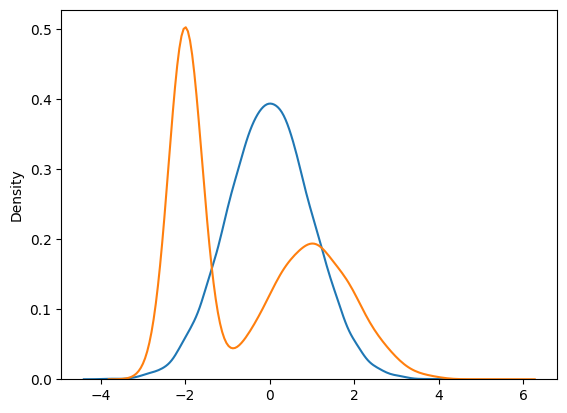

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

num_samples = 10000
target = np.random.normal(0, 1, num_samples)
data = np.concatenate([
    np.random.normal(-2, 0.3, num_samples // 2),
    np.random.normal(1, 1, num_samples // 2)
])

plot = sns.kdeplot(target, label='Target')
plot = sns.kdeplot(data, label='Data')
plt.show()

### Get the lines so we have the distributions ###
target_x, target_y = plot.lines[0].get_data()
data_x, data_y = plot.lines[1].get_data()



The cost of moving mass from point $x$ to point $y$ is $c(x,y) > 0$. The selected transport plan to move from $u$ to $v$ is known as $\gamma(x,y)$ which gives how much should we move from $x$ to $y$? Another way to think about this though is, think about $u$ as a mount of dirt, and invert $v$ to be a hole in the ground. The amount of dirt in $u$, and the hole in $v$ are the exact same size of 1. Then we need to take dirt from $u$ and fill $v$ with it. Once we have filled $v$, we have completed our transport, and the way we moved the dirt is defined by the transport plan.

There is a great package called ```ot``` that can plot the optimal transport matrix, identifying $\gamma$ and how we can optimally move mass from one distribution to another. 

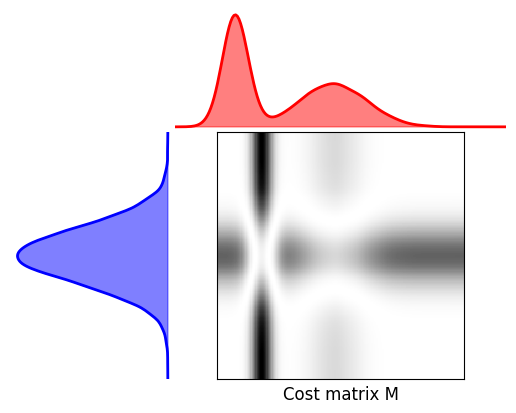

In [5]:
import ot
import ot.plot 

M = ot.dist(target_y.reshape((-1, 1)), data_y.reshape((-1, 1)))
M /= M.max()

ot.plot.plot1D_mat(target_y, data_y, M, "Cost matrix M")
plt.show()

There are some restrictions though on our transport plan though for this to all make sense. 

1. The amount of mass we take out at point $x$ must match the amount of mass that was in our original distribution $u$. Therefore, if we integrate our transport over all the $y$ for some given $x$, we will end up with the amount of dirt that was originally in that spot $x$. Basically, our dirt that was in spot $x$ in distribution $u$ has been redistributed across all potential spots in $v$ indicated by $y$.

$$\int \gamma(x,y)dy = u(x)$$

2. The total mass going into $y$ must match the target distribution $v$. Remember, in our analogy, $v$ is a hole, and we are taking from $u$ and placing into different points $y$ along $v$. Therefore, once our hole is full, taking in dirt from different points in $x$ into a specific point $y$, the total dirt at that point $y$ must match whatever the depth of the hole was at that point $y$ which is defined by $v$

$$\int \gamma(x,y)dx = v(x)$$

Therefore, $\gamma(x,y)$ is just a joint distribution with marginals $u$ and $v$

#### Overall Cost of a Transport Plan 
The transport plan of how much to move from $x$ to another point $y$ is $\gamma(x,y)$ and the cost it incurrs is $c(x,y)$, therefore, our total cost can by their product just as we had done earlier, just summed (or integrated) over all possible $x,y$ combinations:

$$\int\int c(x,y)\gamma(x,y)dxdy$$

#### Optimal Plan
As we saw earlier, the plan is not unique. There are lots of ways to shovel dirt! To find the optimal plan, we need to find one that minimizes our cost.

$$W(u,v) = \inf_{\gamma \in \Pi(u,v)} E_{(x,y) \sim \gamma}[c(x,y)]$$

Where:

- $\Pi(u,v)$ is the set of all possible transport plans
- $\gamma \sim \Pi(u,v)$ is a single one of those transport plans
- $c(x,y)$ is the cost, but typically we use a distance metric for our cost function

Assuming some kind of a Euclidean distance, we can then write our final distance formula as:

$$W(u,v) = \inf_{\gamma \in \Pi(u,v)} E_{(x,y) \sim \gamma}[||x-y||]$$

### Wasserstein vs Jensen-Shannon Divergence 

We proved in our [Intro to Gans](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/Intro%20to%20GANs) that the optimal solution to our traditional GAN can be represented in terms of the Jensen-Shannon Divergence.

$$-2\log(2) + 2 * D_{JS}(p_{data} || p_g)$$

The [WGAN paper](https://arxiv.org/pdf/1701.07875) has an example called parallel lines that makes this clear. I will just place that example here to make it clear!

Let $Z \sim U(0,1)$, a uniform distribution. We then create two joint distributions $P ~ (0,Z)$ and $Q ~ (\theta, Z)$. This is basically two verical lines, one at 0 and another at $\theta$.

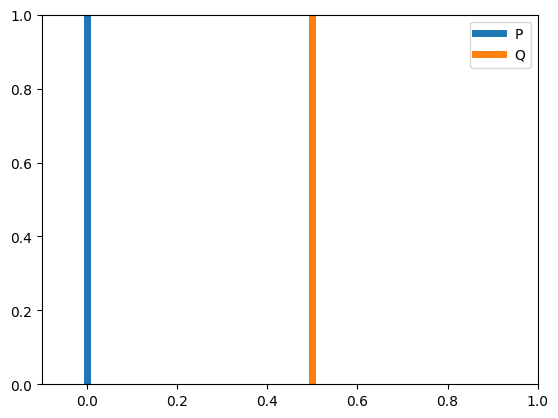

In [3]:
num_samples = 200
theta = 0.5

unif = np.random.uniform(size=(num_samples))

plt.plot(np.array([0 for _ in range(num_samples)]), unif, label="P", linewidth=5)
plt.plot(np.array([theta for _ in range(num_samples)]), unif, label="Q", linewidth=5)
plt.ylim(0,1)
plt.xlim(-0.1,1)
plt.legend()
plt.show()

Notice that, as long as $\theta$ doesnt equal to 0, these vertical lines will never touch! Lets now compute our Jensen Shannon Divergence. 

### Jensen Shannon When $\theta \neq 0$

The formula for the Jensen Shannon Divergence was the average of the KL Divergence in both directions:

$$D_{JS}(Q||P) = \frac{1}{2}D_{KL}(Q||M) + \frac{1}{2}D_{KL}(P||M)$$ 

where:

$$M = \frac{Q+P}{2}$$

$$D_{KL}(A||B) = \int A(x_i) \cdot \log \frac{A(x_i)}{B(x_i)}$$

#### First step, lets compute $M$!

At $x=0$, $P(x) = 1 \text{ and } 0 \text{ elsewhere}$ 

At $x=\theta$, $Q(x) = 1 \text{ and } 0 \text{ elsewhere}$ 

Basically, when $x=0$, all the probability is along the line, so $P(x) = 1$ for everything along the line. On the other hand, for all other $x$. there is no density at all (the vertical line is just at 0) so $P(x) = 0$ This is the same for $Q$, but its line is at $\theta$, and there is no other density elsewhere.

Well, this should remind you of the Dirac Delta Function! The Dirac function $\delta(x)$ is 1 when the argument of the delta function is 0, and 0 elsewhere. Therefore we can write:

$$P(x) = \delta(x)$$
$$Q(x) = \delta(x-\theta)$$

$$M = \frac{P + Q}{2} = \frac{\delta(x) + \delta(x-\theta)}{2} = \frac{1}{2} \text{ if } x \neq \theta$$

Then we can calculate our Jensen Shannon Divergence as the following:

$$D_{JS}(P||Q) = \frac{1}{2}D_{KL}(P||M) + \frac{1}{2}D_{KL}(Q||M)$$ 
$$=  \frac{1}{2} \int P \cdot \log \frac{P}{M}  + \frac{1}{2} \int Q \cdot \log \frac{Q}{M}$$ 
$$=  \frac{1}{2} \int \delta(x) \cdot \log \frac{\delta(x)}{\frac{1}{2}}  + \frac{1}{2} \int \delta(x-\theta) \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ 

In the first term: $$\frac{1}{2} \int \delta(x) \cdot \log \frac{\delta(x)}{\frac{1}{2}}$$ because of the product with $\delta(x)$, this integral only exists at $x=0$ and 0 elsewhere. So we can simplify it to $$\frac{1}{2} \cdot \log \frac{\delta(x)}{\frac{1}{2}}$$ Because this integral only existed $x=0$, we can evaluate $\delta(x)$ at 0, which is just 1, giving us the final $$\frac{1}{2} log(2)$$

In the second term $$\frac{1}{2} \int \delta(x-\theta) \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ this integral only exists at $x=\theta$ and 0 elsewhere. So we can simplify it to $$\frac{1}{2} \cdot \log \frac{\delta(x-\theta)}{\frac{1}{2}}$$ Because this integral only existed $x=\theta$, we can evaluate $\delta(x=\theta)$ at $\theta$, which is just 1, giving us the final $$\frac{1}{2} log(2)$$


Thus, the final Jensen Shannon Divergence can be written as $$\frac{1}{2} log(2) + \frac{1}{2} log(2) = log(2)$$

On the other hand, if $\theta = 0$, then our two vertical lines are identical, and our divergence would just be 0. Therefore:


\begin{equation}
  D_{JS}(P,Q) =
    \begin{cases}
      \log2 & \text{if } \theta \neq 0  \\
      0 & \text{else}\\
    \end{cases}       
\end{equation}

### Wasserstein Distance for Vertical Lines

To compute the cost of transport from the vertical lines, is just to shift our line over from $\theta$ to 0. Therefore the wasserstein distance is just $|\theta|$ **ALWAYS**.

\begin{equation}
  W_{JS}(P,Q) = |\theta|    
\end{equation}

### Stability

Notice the difference in stability in training. The Wasserstein distance provides a smooth measure that is nicely differentiable at all $\theta$. On the other hand The Jensen Shannon jumps from 0 to $\log 2$ which may hurt gradient optimization methods like the ones we use to train Neural Networks!

### Wasserstein Distance for GAN Training ###